# FastHTML By Example

FastHTML is "a library for writing fast and scalable Starlette-powered web applications". The [docs](https://answerdotai.github.io/fasthtml/) show the basic usage, but there are lots of non-FastHTML-specific tricks and patterns involved in building web apps. The goal of this tutorial is to give an alternate introduction to FastHTML, building out a number of example applications to show common patterns and illustrate some of the ways you can build on top of the FastHTML foundations to create your own custom web apps. A secondary goal is to have this be a useful document to add to the context of an LLM to turn it into a useful FastHTML assistant - in fact, in some of the examples we'll see this kind of assistant in action, thanks to [this custom GPT](https://chatgpt.com/g/g-xPqF9SZjM-fasthtml-helper) I made.

Let's get started.

## FastHTML Basics

FastHTML is *just python*. You can install it with `pip install python-fasthtml`, and extensions/components built for it can likewise be distriuted via pypi or as simple python files.

The core usage of FastHTML is to define routes, and then to define what to do at each route. This is similar to the [FastAPI](https://fastapi.tiangolo.com/) web framework (in fact we implemented much of the fuctionality to match the FastAPI usage examples) but where FastAPI focuses on returning JSON data to build APIs, FastHTML focuses on returning HTML data.

Here's a simple FastHTML app that returns a "Hello, World" message:

In [36]:
from fasthtml import FastHTML

app = FastHTML()

@app.get("/")
def home():
    return "<h1>Hello, World</h1>"

To run this app, place it in a file, say `app.py`, and then run it with `uvicorn app:app --reload`. You'll see a message like this:
```
INFO:     Will watch for changes in these directories: ['/home/jonathan/fasthtml-example']
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [871942] using WatchFiles
INFO:     Started server process [871945]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
```

If you navigate to http://127.0.0.1:8000 in a browser, you'll see your "Hello, World". If you edit the `app.py` file and save it, the server will reload and you'll see the updated message when you refresh the page in your browser.

## Constructing HTML with fastcore.xml

Notice we wrote some HTML in the previous example. We don't want to do that! Some web frameworks require that you learn HTML, CSS, Javascript AND some templating language AND python. We want to do as much as possible with just one language. Fortunately, [fastcore.xml](https://fastcore.fast.ai/xml.html) has all we need for constructing HTML from python, and FastHTML includes all the tags you need to get started. For example:

In [47]:
from fasthtml import *
page = Html(
    Head(Title('Some page')),
    Body(Div('Some text', Input(name='me'), Img(src="filename"), cls='myclass'))
)
print(to_xml(page))

<!doctype html>

<html>
  <head>
    <title>
Some page
    </title>
  </head>
  <body>
    <div class="myclass">
Some text
      <input name="me">
      <img src="filename">
    </div>
  </body>
</html>



If that `import *` worries you, you can always import only the tags you need. 

FastHTML is smart enough to know about fastcore.xml, and so you don't need to use the `to_xml` function to convert your XT objects to HTML. You can just return them as you would any other python object. For example, if we modify our previous example to use fastcore.xml, we can return an XT object directly:

In [48]:
app = FastHTML()

@app.get("/")
def home():
    return Div(H1('Hello, World'), P('Some text'), P('Some more text'))




This will render the HTML in the browser:

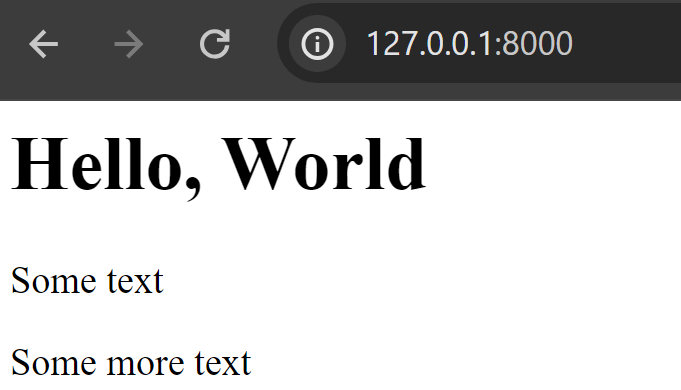

For debugging, you can right-click on the rendered HTML in the browser and select "Inspect" to see the underlying HTML that was generated. There you'll also find the 'network' tab, which shows you the requests that were made to render the page. Refresh and look for the request to `127.0.0.1` - and you'll see it's just a `GET` request to `/`, and the response body is the HTML you just returned.

You can also use Starlette's `TestClient` to try it out in a notebook: 

In [49]:
from starlette.testclient import TestClient
client = TestClient(app)
r = client.get("/")
r.text

'<div>\n  <h1>\nHello, World\n  </h1>\n  <p>\nSome text\n  </p>\n  <p>\nSome more text\n  </p>\n</div>\n'

## Defining Routes



The HTTP protocol defines a number of methods ('verbs') to send requests to a server. The most common are GET, POST, PUT, DELETE, and HEAD. We saw 'GET' in action before - when you navigate to a URL, you're making a GET request to that URL. We can do different things on a route for different HTTP methods. For example:

```python
@app.route("/", methods='get')
def home():
    return H1('Hello, World')

@app.route("/", methods=['post', 'put'])
def post():
    return "got a post or put request"
```

This says that when someone navigates to the root URL "/" (i.e. sends a GET request), they will see the big "Hello, World" heading. When someone submits a POST or PUT request to the same URL, the server should return the string "got a post or put request".

Aside: You can test the POST request with `curl -X POST http://127.0.0.1:8000 -d "some data"`. This sends some data to the server, you should see the response "got a post or put request" printed in the terminal.

There are a few other ways you can specify the route+method - FastHTML has `.get`, `.post`, etc. as shorthand for `route(..., methods=['get'])`, etc.

In [44]:
@app.get("/")
def my_function():
    return "Hello World from a get request"

 Or you can use the `@app.route` decorator without a method but specify the method with the name of the function. For example:

In [ ]:
@app.route("/")
def post():
    return "Hello World from a post request"

In [45]:
client.post("/").text

'Hello World from a post request'

You're welcome to pick whichever style you prefer. Using routes let's you show different content on different pages - '/home', '/about' and so on. You can also respond differently to different kinds of requests to the same route, as we shown above. Later on we'll see how to pass in data to routes, and how to use it to show different content.

## Styling Basics

Plain HTML probably isn't quite what you imagine when you visualize your beautiful web app. CSS is the go-to language for styling HTML. But again, we don't want to learn extra languages unless we absolutely have to! Fortunately, there are ways to get much more visually appealing sites by relying on the hard work of others, using existing CSS libraries. One of our favourites is [PicoCSS](https://picocss.com/). To add a CSS file to HTML, you can use the `<link>` tag. Since we typically want things like CSS styling on all pages of our app, FastHTML lets you add shared headers when you define your app. And it already has `picolink` defined for convenience. As per the [pico docs](https://picocss.com/docs), we put all of our content inside a `<main>` tag with a class of `container`: 



```python
from fasthtml import FastHTML, picolink
from fastcore.xml import *

# App with custom styling to override the pico defaults
css = Style(':root { --pico-font-size: 100%; --pico-font-family: Pacifico, cursive;}')
app = FastHTML(hdrs=(picolink, css))

@app.route("/")
def get():
    return Title("Hello World"), Main(H1('Hello, World'), cls="container")
```

You can check out the pico [examples](https://picocss.com/examples) page to see how different elements will look. If everything is working, the page should now render nice text with our custom font, and it should respect the user's light/dark mode preferences too.

If you want to [override the default styles](https://picocss.com/docs/css-variables) or add more custom CSS, you can do so by adding a `<style>` tag to the headers as shown above. So you are allowed to write CSS to your heart's content - we just want to make sure you don't necessarily have to! Later on we'll see examples using other component libraries and tailwind css to do more fancy styling things, along with tips to get an LLM to write all those fiddly bits so you don't have to.

Aside: We're returning a tuple here (a title and the main page). With HTMX if you pass in a title tag first it updates the window title - more on this when we get to HTMX.

## Web Page -> Web App

Showing content is all well and good, but we typically expect a bit more *interactivity* from something calling itself a web app! So, let's add a few different pages, and use a form to let users add messages to a list:

In [46]:
app = FastHTML()
messages = ["This is a message, which will get rendered as a paragraph"]

@app.get("/")
def home():
    return Main(H1('Messages'), 
                *[P(msg) for msg in messages],
                A("Link to Page 2 (to add messages)", href="/page2"))

@app.get("/page2")
def page2():
    return Main(P("Add a message with the form below:"),
                Form(Input(type="text", name="data"),
                    Button("Submit"),
                    action="/", method="post"))

@app.post("/")
def add_message(data:str):
    messages.append(data)
    return home()

Alternatively, we could have the form send the data to a new route (say, `/add_message`), and have that route add the message to the list of messages before redirecting to the homepage:

```python
from starlette.responses import RedirectResponse

...

@app.post("/")
def add_message(data:str):
    messages.append(data)
    return RedirectResponse(url="/")
```

In either case, we re-render the entire homepage to show the newly added message. This is fine, but modern web apps often don't re-render the entire page, they just update a part of the page. In fact even very complicated applications are often implemented as 'Single Page Apps' (SPAs). This is where HTMX comes in.

## HTMX

[HTMX](https://htmx.org/) addresses some key limitations of HTML. In vanilla HTML, links can trigger a GET request to show a new page, and forms can send requests containing data to the server. A lot of 'Web 1.0' design revolved around ways to use these to do everything we wanted. But why should only *some* elements be allowed to trigger requests? And why should we refresh the *entire page* with the result each time one does? HTMX extends HTML to allow us to trigger requests from *any* element on all kinds of events, and to update a part of the page without refreshing the entire page. It's a powerful tool for building modern web apps.

It does this by adding attributes to HTML tags to make them do things. For example, here's a page with a counter and a button that increments it:

In [50]:
app = FastHTML()

count = 0

@app.get("/")
def home():
    return Title("Count Demo"), Main(
        H1("Count Demo"),
        P(f"Count is set to {count}", id="count"),
        Button("Increment", hx_post="/increment", hx_target="#count", hx_swap="innerHTML")
    )

@app.post("/increment")
def increment():
    print("incrementing")
    global count
    count += 1
    return f"Count is set to {count}"

NB: You must return a title first here or the HTMX headers aren't added (??)

The button triggers a POST request to `/increment` (since we set `hx_post="increment"`), which increments the count and returns the new count. The `hx_target` attribute tells HTMX where to put the result. If no target is specified it replaces the element that triggered the request. The `hx_swap` attribute specifies how it adds the result to the page. The options are:
- `innerHTML`: Replace the target element's content with the result.
- `outerHTML`: Replace the target element with the result.
- `beforebegin`: Insert the result before the target element.
- `beforend`: Insert the result after the target element.
- `afterbegin`: Insert the result inside the target element, before its first child.
- `afterend`: Insert the result inside the target element, after its last child.

You can also use an hx_swap of `delete` to delete the target element regardless of response, or of `none` to do nothing.

By default, requests are triggered by the “natural” event of an element - click in the case of a button (and most other elements). You can also specify different triggers, along with various modifiers - see the [HTMX docs](https://htmx.org/docs/#triggers) for more.

This pattern of having elements trigger requests that modify or replace other elements is a key part of the HTMX philosophy. It takes a little getting used to, but once mastered it is extremely powerful.

## More on Routing and Request Parameters

In [ ]:
app = FastHTML()
rt = app.route

In [ ]:
from starlette.testclient import TestClient
cli = TestClient(app)

In [ ]:
@app.get('/html/{idx}')
async def _(idx:int):
    return Body(
        H4("Wow look here"),
        P(f'It looks like you are visitor {idx}! Next is {idx+1}.')
    )

from IPython import display
display.HTML(cli.get('/html/1').text)

In [ ]:
@app.get('/user/{nm}')
def _(nm:str): return f"Good day to you, {nm}!"

cli.get('/user/jph').text

'Good day to you, jph!'

In [ ]:
@rt('/html/{idx}')
async def get(idx:int):
    return Body(
        H4("Wow look here"),
        P(f'It looks like you are visitor {idx}! Next is {idx+1}.')
    )

display.HTML(cli.get('/html/1').text)

In [ ]:
reg_re_param("imgext", "ico|gif|jpg|jpeg|webm")

@app.get(r'/static/{path:path}{fn}.{ext:imgext}')
def get_img(fn:str, path:str, ext:str): return f"Getting {fn}.{ext} from /{path}"

cli.get('/static/foo/jph.ico').text

'Getting jph.ico from /foo/'

In [ ]:
ModelName = str_enum('ModelName', "alexnet", "resnet", "lenet")

@app.get("/models/{nm}")
def model(nm:ModelName): return nm

print(cli.get('/models/alexnet').text)

alexnet


In [ ]:
@app.get("/files/{path}")
async def txt(path: Path): return path.with_suffix('.txt')

print(cli.get('/files/foo').text)

foo.txt


In [ ]:
fake_db = [{"name": "Foo"}, {"name": "Bar"}]

@app.get("/items/")
def read_item(idx:int|None = 0): return fake_db[idx]

print(cli.get('/items/?idx=1').text)

{"name":"Bar"}


In [ ]:
print(cli.get('/items/').text)

{"name":"Foo"}


In [ ]:
@app.get("/booly/")
def booly(coming:bool=True): return 'Coming' if coming else 'Not coming'

print(cli.get('/booly/?coming=true').text)

Coming


In [ ]:
print(cli.get('/booly/?coming=no').text)

Not coming


In [ ]:
@app.get("/datie/")
def datie(d:date): return d

date_str = "17th of May, 2024, 2p"
print(cli.get(f'/datie/?d={date_str}').text)

2024-05-17 14:00:00


In [ ]:
@dataclass
class Bodie:
    a:int;b:str

@rt("/bodie/{nm}")
async def post(nm:str, data:Bodie):
    res = asdict(data)
    res['nm'] = nm
    return res

cli.post('/bodie/me', data=dict(a=1, b='foo')).text

'{"a":1,"b":"foo","nm":"me"}'

In [ ]:
@app.get("/setcookie")
async def setc(req):
    now = datetime.now()
    res = Response(f'Set to {now}')
    res.set_cookie('now', str(now))
    return res

cli.get('/setcookie').text

'Set to 2024-06-04 10:13:20.378990'

In [ ]:
@app.get("/getcookie")
async def getc(now:date): return f'Cookie was set at time {now.time()}'

cli.get('/getcookie').text

'Cookie was set at time 10:13:20.378990'

In [ ]:
@app.get("/ua")
async def ua(user_agent:str): return user_agent

cli.get('/ua', headers={'User-Agent':'FastHTML'}).text

'FastHTML'

In [ ]:
@app.get("/hxtest")
def hxtest(htmx): return htmx.request

cli.get('/hxtest', headers={'HX-Request':'1'}).text

'1'

## Chatbot Example: DaisyUI Components

We're going to build a simple chatbot app that looks like this:

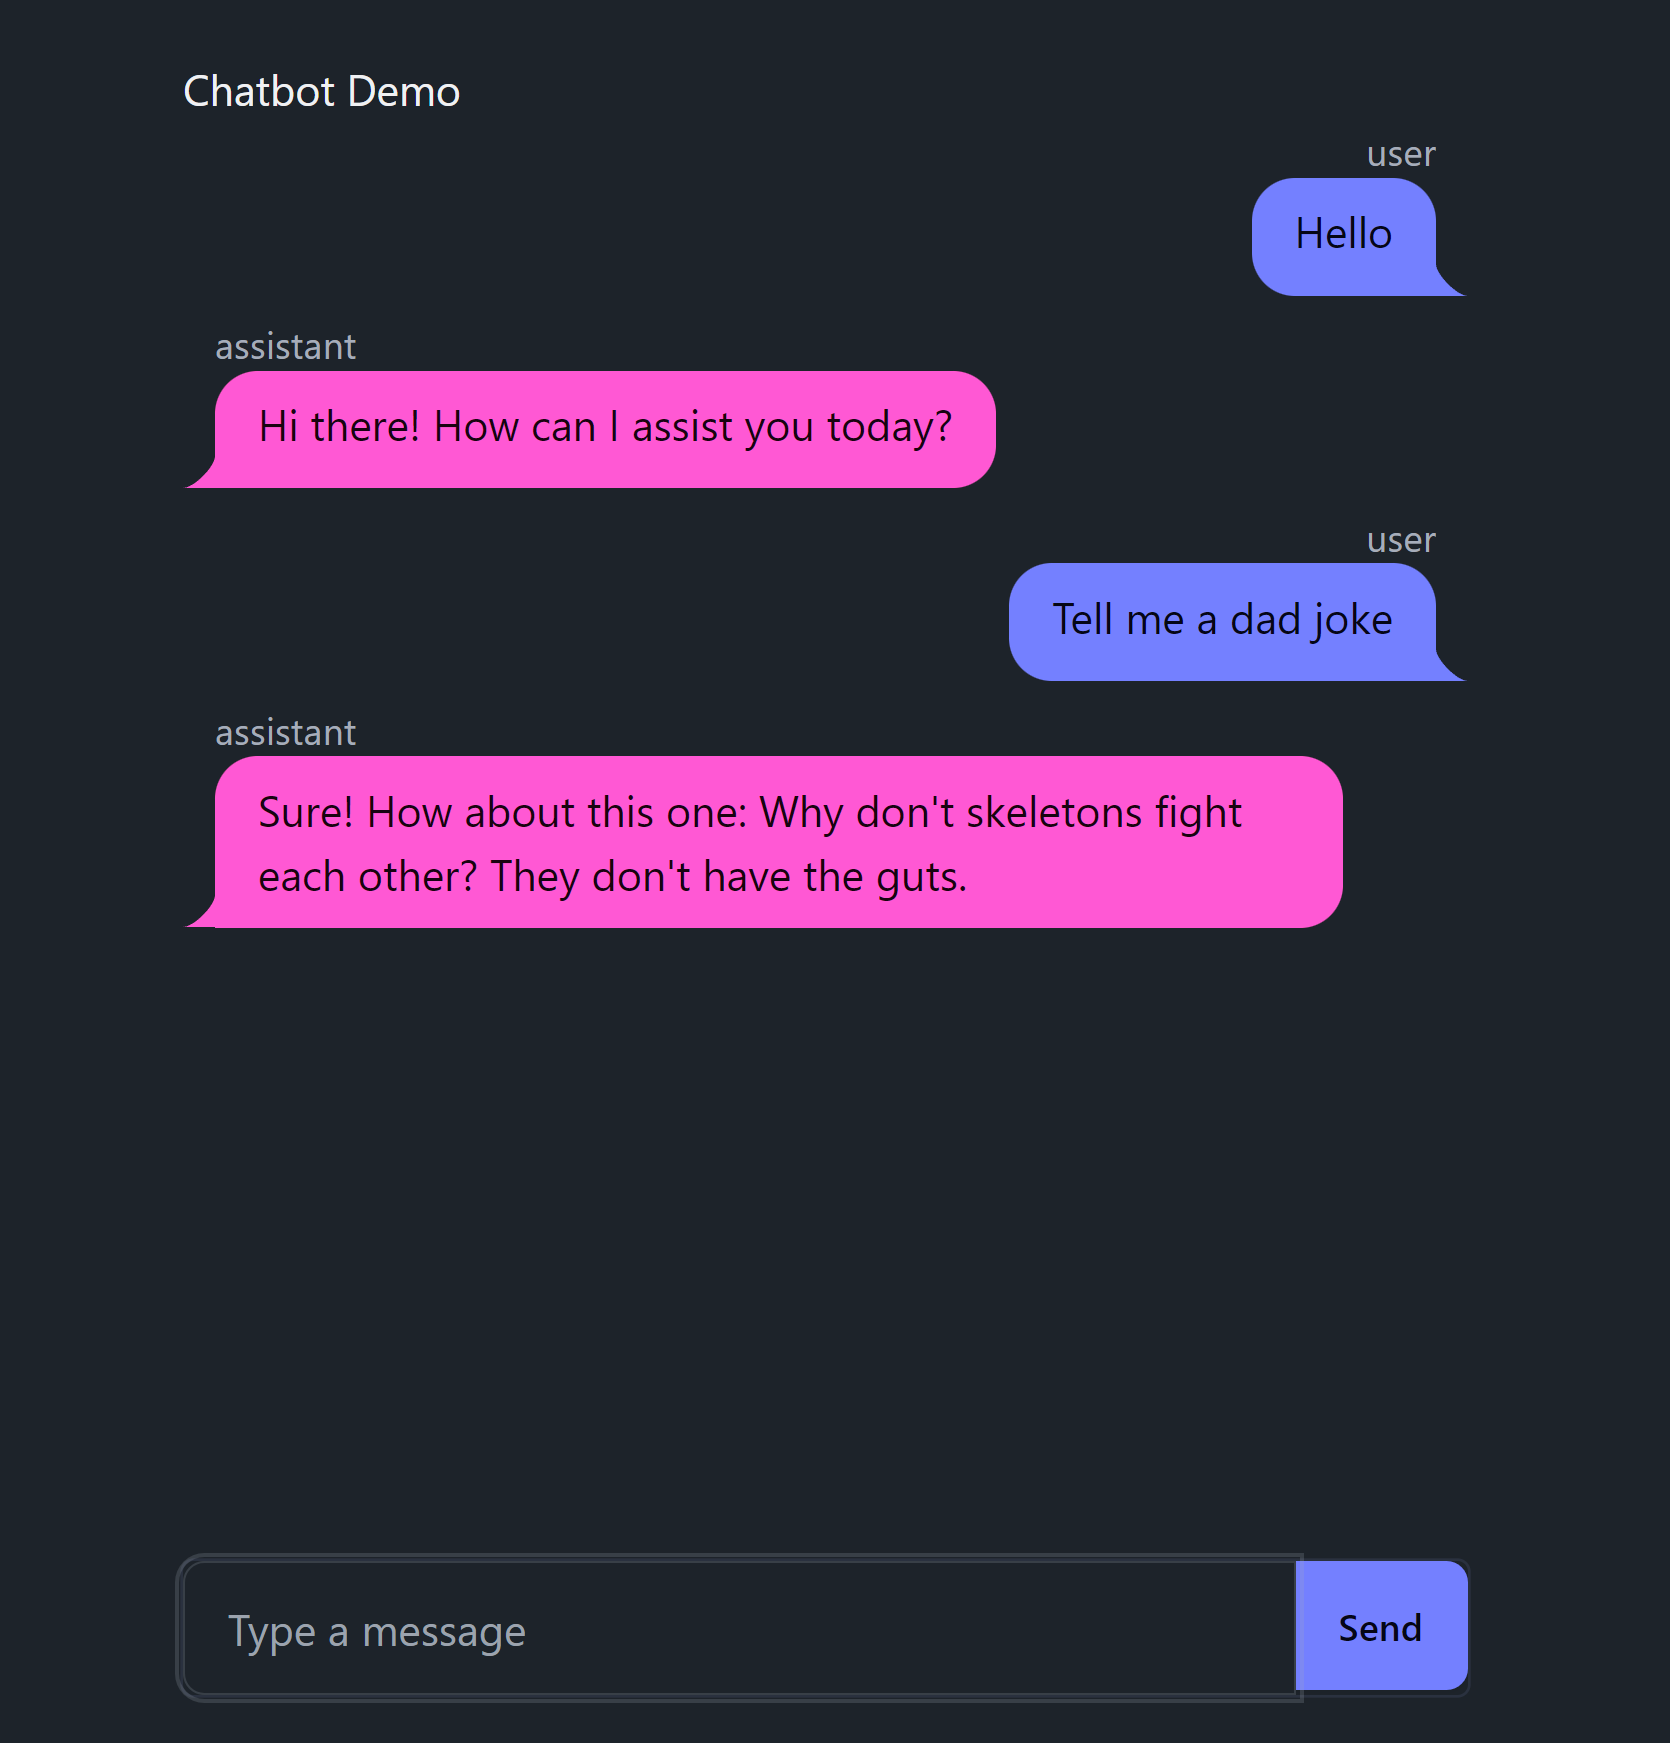

Bla bla

Test
![Using the FastHTML Helper GPT to avoid learning tailwind.](<attachment:Screenshot 2024-06-03 110047.png>)
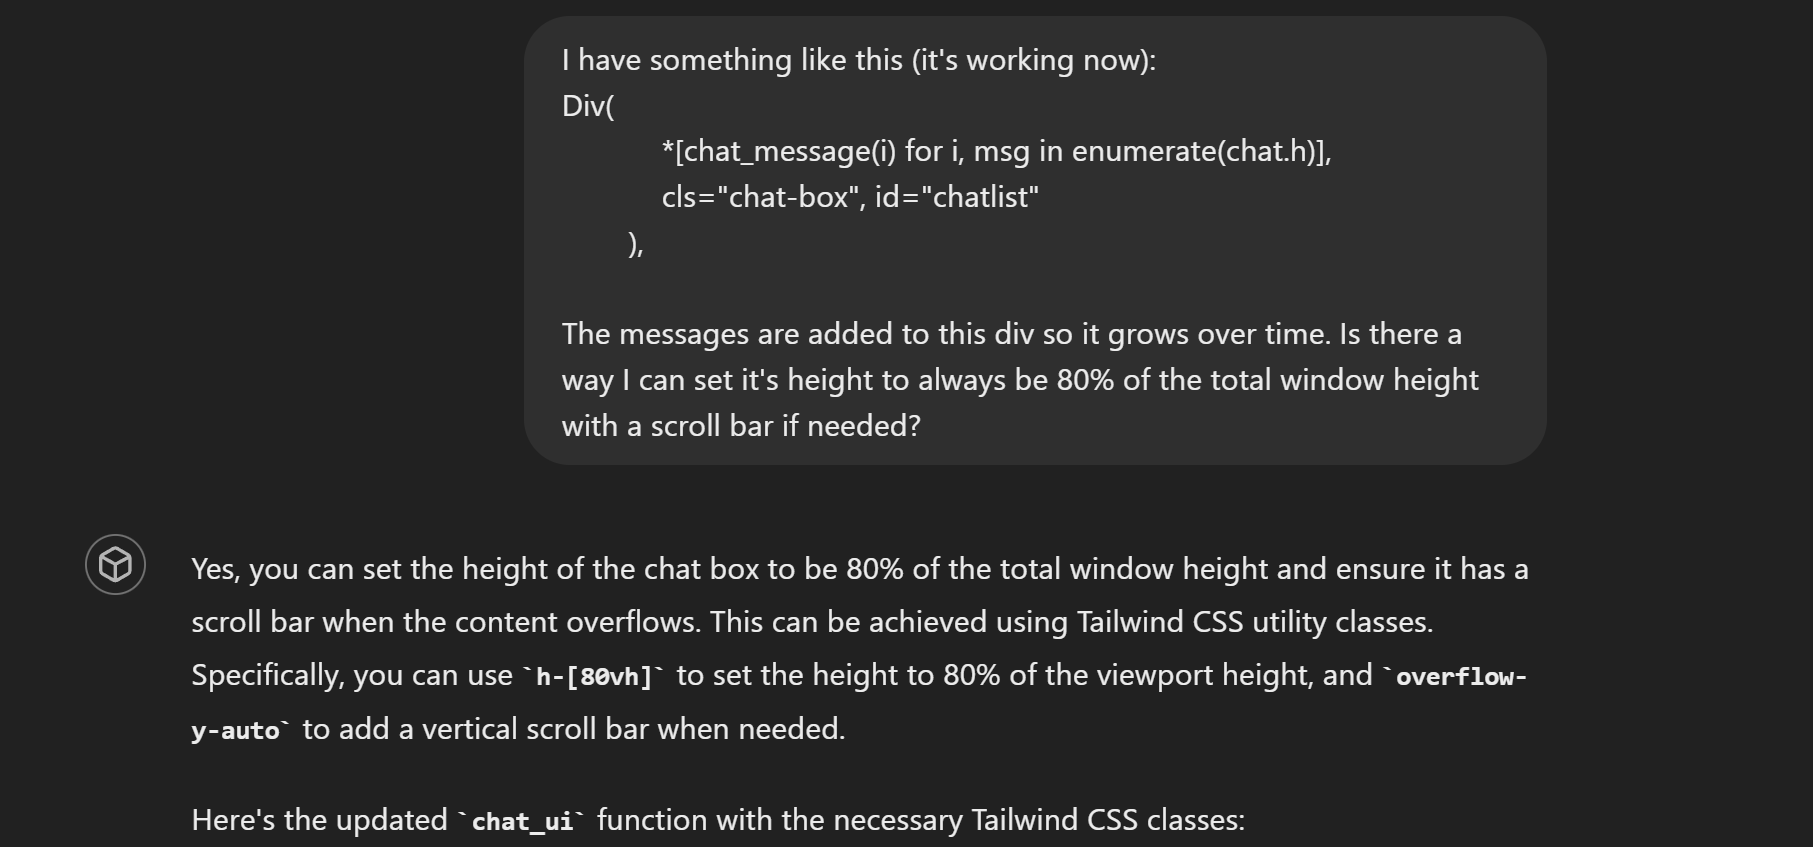

TODO show code

```python
from starlette.responses import FileResponse
from fastcore.utils import *
from fastcore.xml import *
from fasthtml import *
from cosette import *

tlink = Script(src="https://cdn.tailwindcss.com"),
dlink = Link(rel="stylesheet", href="https://cdn.jsdelivr.net/npm/daisyui@4.11.1/dist/full.min.css")
app = FastHTML(hdrs=(picolink, tlink, dlink))

chat = Chat(models[0], sp="""You are a helpful and concise assistant.""")

def chat_message(msg):
    msg = dict(msg)
    if type(msg['content']) == list: msg['content'] = msg['content'][0]['text']
    return Div(
        Div(msg['role'], cls="chat-header"),
        Div(msg['content'], cls=f"chat-bubble chat-bubble-{'primary' if msg['role'] == 'user' else 'secondary'}"),
        cls=f"chat chat-{'end' if msg['role'] == 'user' else 'start'}")

@app.route("/")
def get():
    inp = Input(type="text", name='msg', id='msg-input', 
                  placeholder="Type a message", cls="input input-bordered w-full")
    page = Main(H1('Chatbot Demo'), 
                Div(cls="chat-box h-[73vh] overflow-y-auto", id="chatlist"),
                Form(Group(inp, Button("Send", cls="btn btn-primary")),
                    cls="flex space-x-2 mt-2",hx_post="/", hx_swap="beforeend",
                    target_id="chatlist", hx_target="#chatlist"
                ), cls="p-4 max-w-lg mx-auto")
    return Title('Chatbot Demo'), page

@app.post("/")
async def post(request:Request):
    form_data = await request.form()
    chat(form_data['msg'])
    clear_chat_box = Input(type="text", name='msg', id='msg-input', placeholder="Type a message", 
                           cls="input input-bordered w-full", hx_swap_oob='true')
    return chat_message(chat.h[-2]), chat_message(chat.h[-1]), clear_chat_box

@app.get("/{fname:path}.{ext:static}")
def static(fname:str, ext:str): return FileResponse(f'{fname}.{ext}')

```

TODO exlpain in sections

In [8]:
# todo GRoup is defined in fasthtml.xtend and needs pico

## TODO



- Getting data from the request
- Forms example
- Static Files
- Databases with fastlite
- HTMX
    - Basics
    - OOB
    - Polling with trigger = every 1s
- Sessions and cookies
- Payments with Stripe (image demo example)
- DaisyUI components (chatbot example)
- Custom styling (sketchy example)
- Password-protecting a site (simple auth example)
- OAuth
- WebSockets (chatbot redux)
- Starlette Responses (RedirectResponse, etc)

## XT objects and HTML

These XT objects create an XML tag structure [tag,children,attrs] for `toxml()`. When we call `Div(...)`, the elements we pass in are the children. Attributes are passed in as keywords. `class` and `for` are special words in python, so we use `cls`, `klass` or `_class` instead of `class` and `fr` or `_for` instead of `for`. Note these objects are just 3-element lists - you can create custom ones too as long as they're also 3-element lists. Alternately, leaf nodes can be strings instead (which is why you can do `Div('some text')`). If you pass something that isn't a 3-element list or a string, it will be converted to a string using str()... unless (our final trick) you define a `__xt__` method that will run before str(), so you can render things a custom way.

For example, here's one way we could make a custom class that can be rendered into HTML:

In [10]:
class Person:
    def __init__(self, name, age):
        self.name = name
        self.age = age

    def __xt__(self):
        return ['div', [f'{self.name} is {self.age} years old.'], {}]

p = Person('Jonathan', 28)
print(to_xml(Div(p, "more text", cls="container")))

<div class="container">
  <div>
Jonathan is 28 years old.
  </div>
more text
</div>



In the examples (todo link) you'll see we often patch in `__to_xml__` methods to existing classes to control how they're rendered.


## Deploying Your App


Deploy on render etc